# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

> 우리는 입력 이미지들의 픽셀 정보로 선형 분류기를 훈련했을 때 괜찮은 수준의 정확도를 얻을 수 있었습니다. 이번에는 입력 이미지들의 픽셀 정보가 아니라, 픽셀 정보에서 얻은 특징(feature)들으로 선형 분류기를 훈련했을 때 더 정확한 분류가 가능한지 한 번 알아보도록 하겠습니다.

All of your work for this exercise will be done in this notebook.

> 이번 연습문제는 전부 이 노트북에서 진행됩니다.

* Linear Classifier / Linear SVM은 Lecture 3 발표자 [mujjingun](https://gitlab.com/mujjingun/)의 소스코드를 사용하였습니다. ([Linear Classifier](https://gitlab.com/mujjingun/cs231n-solutions-ailoli/blob/master/cs231n/classifiers/linear_classifier.py), [Linear SVM](https://gitlab.com/mujjingun/cs231n-solutions-ailoli/blob/master/cs231n/classifiers/linear_svm.py))
* Neural Net은 직접 구현했습니다.

In [2]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

* `from __future__ import print_function` 가 첫 번째 줄이 아닌 곳에 있으면 오류가 나기 때문에 이 줄을 맨 위로 옮겼습니다.

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.
> 예전 연습문제들과 같은 방법으로 CIFAR-10 데이터를 불러오겠습니다.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

In [4]:
# 잘 읽었나 테스트해 봅시다
print(X_train.shape)

(49000, 32, 32, 3)


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.
> 이미지 하나하나마다 이미지의 여러 특징 중 하나인 HOG를 계산하고, HSV 공간의 색상(Hue) 값으로 색상 히스토그램을 계산합니다.
이 두 히스토그램을 붙여서 특징 벡터를 만들겠습니다.

> HOG(Histogram of Oriented
Gradients)에 대한 설명은 https://donghwa-kim.github.io/hog.html 에서, HSV(Hue, Saturation, Value)에 대한 설명은 https://ko.wikipedia.org/wiki/HSV_%EC%83%89_%EA%B3%B5%EA%B0%84 에서 확인할 수 있습니다.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

> 간단히 말하자면, HOG는 이미지의 색상을 무시하면서 이미지의 질감을 담고 있는 정보이고, 
색상 히스토그램은 반대로 질감을 무시하면서 이미지의 색상 분포만을 담고 있는 정보입니다.
하나씩 각각 사용하는 것보다 두 정보를 합쳐서 사용하는 게 결과적으로는 이득일 거라고 생각해요.
심심하다면 이 두 개를 같이 쓰는 게 하나하나 따로 쓰는 것보다 더 효과적인지 아닌지 직접 확인해 보는 것도
좋을 것 같습니다.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The `extract_features`
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

> `hog_feature`와 `color_histogram_hsv` 함수는 이미지 하나를 받아서 각각 HOG와 색상 히스토그램을
계산합니다. `extract_features`는 각각의 이미지에 대해 이 함수들을 실행해서, 각 행마다 이 두 함수들의 결과를
합쳐 놓은 데이터를 담고 있는 행렬을 만듭니다.

In [5]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

> 전에 쓰였던 멀티클래스 SVM을 위에서 얻은 특징들로 훈련해 봅시다. 픽셀들로 훈련하는 것보다 더 나은 정확도를 얻을 수 있을 것입니다.

In [12]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

# Assignment 1-3과 같은 batch_size와 num_iters를 사용했습니다.

for learning_rate in learning_rates: # 각각의 learning rate에 대해..
    for regularization_strength in regularization_strengths: # 각각의 regularization strength에 대해..
        # Linear SVM 돌리기. 트레이닝은 이 친구가 다 알아서 합니다
        svm = LinearSVM()
        
        svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=regularization_strength,
                      batch_size=200, num_iters=500, verbose=False)
        
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        # 정확도 저장!
        results[(learning_rate, regularization_strength)] = (train_accuracy, val_accuracy)

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.093510 val accuracy: 0.091000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.098633 val accuracy: 0.098000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.095653 val accuracy: 0.103000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.126796 val accuracy: 0.126000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.117245 val accuracy: 0.140000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.392959 val accuracy: 0.378000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.246449 val accuracy: 0.261000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.411633 val accuracy: 0.412000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.322245 val accuracy: 0.333000
best validation accuracy achieved during cross-validation: 0.412000


In [14]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.418


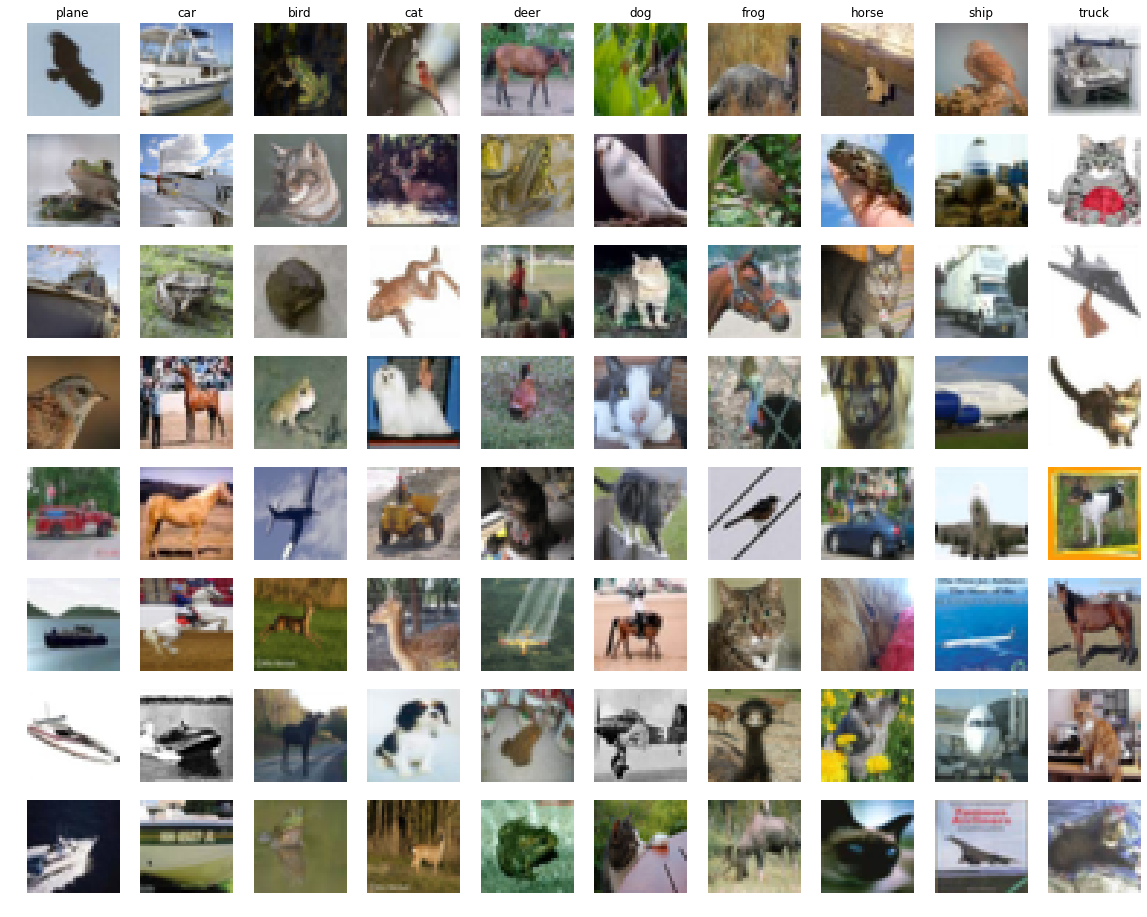

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

# 이미지 크기를 좀 키웠습니다
plt.rcParams['figure.figsize'] = (20.0, 16.0)

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
> 잘못 분류된 결과들이 그렇게 분류되어 있는 건 왜 그런 것 같나요?

* 잘못 분류된 것들도 그래도 예상한 분류와 윤곽선이나 색상이 비슷해 보이긴 합니다. 예를 들어 실제로는 plane인데 ship으로 분류된 한 사진의 경우 윤곽 선이나 색상 배치가 ship과 비슷해 보입니다. HOG하고 색상 히스토그램을 같이 보는 게 좋은지는 잘 모르겠습니다. 그래도 픽셀만으로 훈련한 것보다는 조금 더 높은 (0.35 < 0.42) 정확도를 보였습니다.
* 정확도 0.35는 [Assignment 1-3](https://gitlab.com/mujjingun/cs231n-solutions-ailoli/blob/master/svm.ipynb)에서 얻은 결과입니다.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 
> 예전 연습문제에서 픽셀만 가지고 훈련했을 때 레이어가 2개인 인공신경망이 선형 분류기보다 더 정확했음을 확인했습니다. 또한 이번 연습문제에서는 선형 분류기에서도 이미지 픽셀이 아닌 이미지의 특징을 가지고 훈련하면 더 높은 정확도가 나오는 것을 확인할 수 있었습니다.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.
> 그렇다면 레이어가 2개인 인공신경망을 이미지의 특징을 가지고 훈련한다면 더 높은 정확도를 얻을 수 있을 것입니다. 실제로 레이어가 2개인 네트워크에서는 정확도 55% 정도는 쉽게 달성할 수 있습니다. 우리가 훈련한 좋은 모델은 60% 정도의 정확도를 보였습니다.

In [10]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [23]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

# 여기도 Assignment 1-4와 같은 batch_size와 num_iters를 사용해야 하는데..
# 아이올리 Assignment 1-4 레포지토리를 찾을 수 없어서 임의의 batch_size와 num_iters를
# 사용했습니다.

stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=200, learning_rate=1, learning_rate_decay=0.95,
            reg=0.0, verbose=True)

val_accuracy = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_accuracy)

best_net = net

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 1.436544
iteration 200 / 2000: loss 1.313417
iteration 300 / 2000: loss 1.249092
iteration 400 / 2000: loss 1.406870
iteration 500 / 2000: loss 1.423262
iteration 600 / 2000: loss 1.018759
iteration 700 / 2000: loss 1.109440
iteration 800 / 2000: loss 1.353405
iteration 900 / 2000: loss 1.143687
iteration 1000 / 2000: loss 0.947127
iteration 1100 / 2000: loss 0.838222
iteration 1200 / 2000: loss 0.935781
iteration 1300 / 2000: loss 0.877553
iteration 1400 / 2000: loss 0.814258
iteration 1500 / 2000: loss 0.919644
iteration 1600 / 2000: loss 0.763732
iteration 1700 / 2000: loss 0.748029
iteration 1800 / 2000: loss 0.697788
iteration 1900 / 2000: loss 0.893991
Validation accuracy:  0.579


In [24]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.56


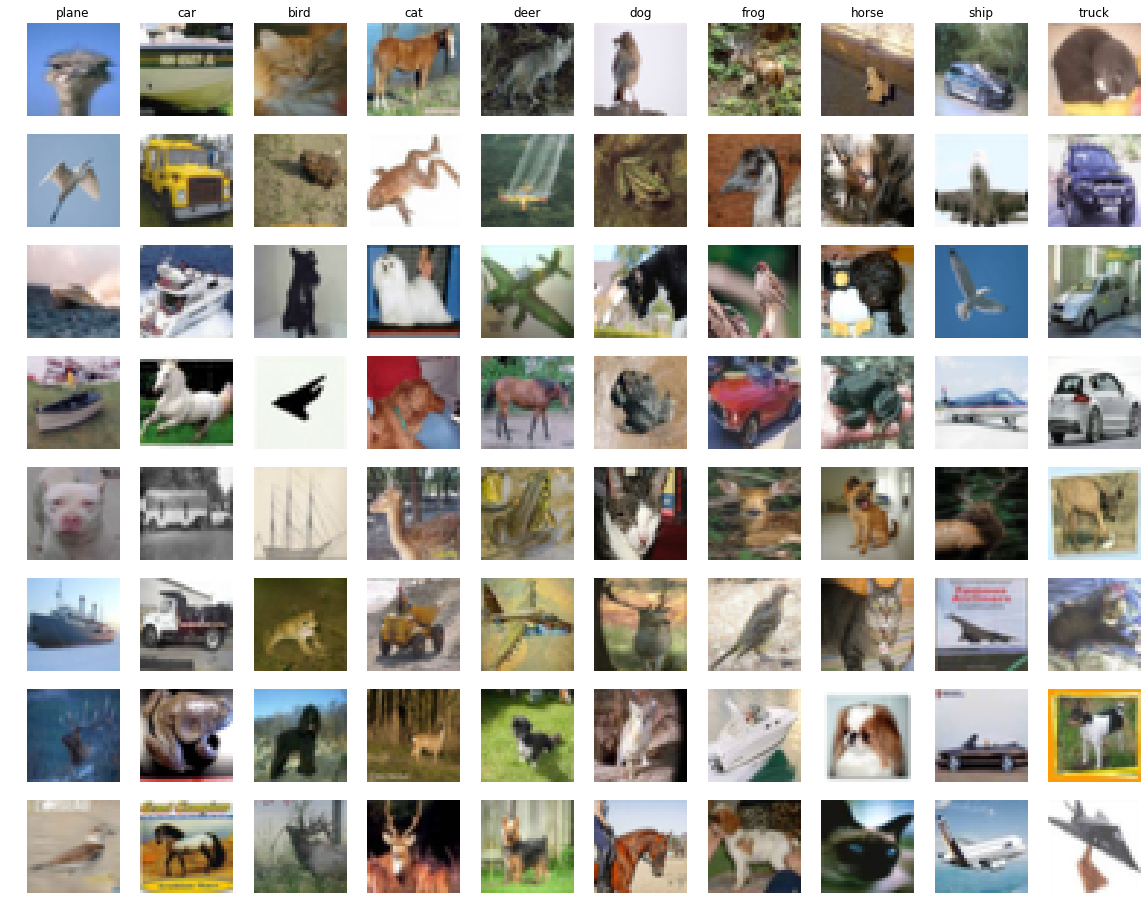

In [25]:
# 이미지 크기를 좀 키웠습니다
plt.rcParams['figure.figsize'] = (20.0, 16.0)

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()